In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import countergen

In [3]:
from countergen.augmentation import Dataset
ds = Dataset.from_jsonl("D:\_Docs\Programmation\Python\Counterfactual-Dataset-Generator\countergen\data\datasets\doublebind.jsonl")

In [4]:
from countergen.augmentation import SimpleAugmenter
augmenters = [SimpleAugmenter.from_default("gender")]

In [5]:
aug_ds = ds.augment(augmenters)

100%|██████████| 9/9 [00:00<00:00, 27.37it/s]


In [6]:
from countergen.evaluation import get_generative_model_evaluator, pt_to_generative_model
from countergen.tools.utils import get_device
from transformers import GPT2LMHeadModel
import torch

model_names = ["distilgpt2"]
device = get_device()
model: torch.nn.Module = GPT2LMHeadModel.from_pretrained(model_names[0]).to(device)
model_ev = get_generative_model_evaluator(pt_to_generative_model(model), "probability")

In [7]:
aggregator = countergen.evaluation.PerformanceStatsPerCategory()

In [8]:
results = countergen.evaluation.evaluate(aug_ds.samples, model_ev, aggregator)

100%|██████████| 9/9 [00:04<00:00,  2.23it/s]


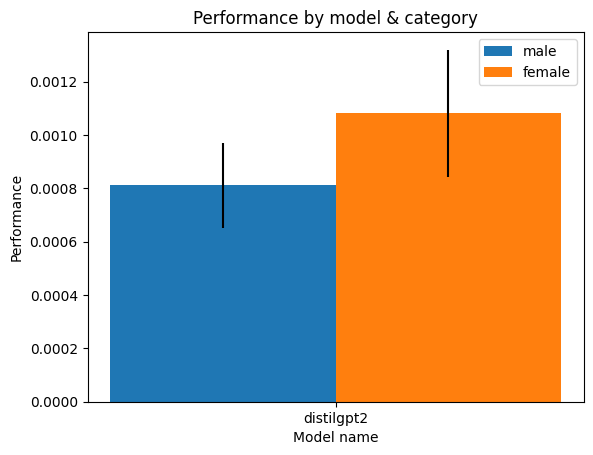

In [9]:
aggregator.display({"distilgpt2":results})

## 7. Edit...

In [10]:
from countergen.editing import ActivationsDataset, get_mlp_modules
layers_dict = get_mlp_modules(model, [2,3])
layers = list(layers_dict.values())
act_ds = ActivationsDataset.from_augmented_samples(aug_ds.samples, model, layers)

In [11]:
act_ds.x_data.shape

torch.Size([2942, 768])

In [ ]:
from countergen.editing.direction_algos import rlace
dirs = rlace(act_ds, n_dim=2, out_iters=100, num_clfs_in_eval=1, evalaute_every=50)

In [19]:
d = 300
n = 1000
permutation = torch.randperm(len(act_ds.x_data))
r_act_ds = ActivationsDataset(
    act_ds.x_data[permutation][:n, :d],
    act_ds.y_data[permutation][:n]
)
r_act_ds_dev = ActivationsDataset(
    act_ds.x_data[permutation][n:2*n, :d],
    act_ds.y_data[permutation][n:2*n]
)

In [21]:
from countergen.editing.direction_algos import rlace
dirs = rlace(r_act_ds, dev_ds=r_act_ds_dev, n_dim=2, out_iters=75000, num_clfs_in_eval=1, evalaute_every=1000)

24000/75000. Acc post-projection: 51.700%; best so-far: 50.700%; Maj: 50.500%; Gap: 0.200%; best loss: 2.8555; current loss: 1.2360:  33%|###3      | 24957/75000 [04:22<08:46, 94.99it/s] 


KeyboardInterrupt: 